In [1]:
from datasets.get_datasets import *
import time
from src.genetic import *

from src.predicate import *
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [189]:
bk = {
      'yeast2': ['cites(+paper,+paper).',
                 'cites(+paper,-paper).',
                 'cites(-paper,+paper).',
                 'gene(+paper,+gene).',
                 'gene(-paper,+gene).',
                 'gene(+paper,-gene).',
                 'year(+paper,+year).',
                 'year(+paper,-year).',
                 'year(-paper,+year).',
                 'journal(+paper,+journal).',
                 'journal(-paper,+journal).',
                 'journal(+paper,-journal).',
                 'author(+paper,+author).',
                 'author(+paper,-author).',
                 'author(-paper,+author).',
                 'fauthor(+paper,+author).',
                 'fauthor(+paper,-author).',
                 'fauthor(-paper,+author).',
                 'lauthor(+paper,+author).',
                 'lauthor(-paper,+author).',
                 'lauthor(+paper,-author).',
                 'title(+paper,+word).',
                 'title(+paper,-word).',
                 'title(-paper,+word).',
                 #Aspect(paper,gene,*R)
                 'chem(+paper,+chemical).',
                 'chem(+paper,-chemical).',
                 'chem(-paper,+chemical).',
                 'dmhead(+paper,+descriptor).',
                 'dmhead(+paper,-descriptor).',
                 'dmhead(-paper,+descriptor).',
                 'qmhead(+paper,+qualifier).',
                 'qmhead(-paper,+qualifier).',
                 'qmhead(+paper,-qualifier).'],
    'yeast': ['location(+protein,+loc).',
                'location(+protein,-loc).',
                'location(-protein,+loc).',
                'interaction(+protein,+protein).',
                'interaction(+protein,-protein).',
                'interaction(-protein,+protein).',
                'proteinclass(+protein,+class).',
                'proteinclass(+protein,-class).',
                'proteinclass(-protein,+class).',
                'enzyme(+protein,+enz).',
                'enzyme(+protein,-enz).',
                'enzyme(-protein,+enz).',
                'function(+protein,+fun).',
                'function(+protein,-fun).',
                'function(-protein,+fun).',
                'complex(+protein,+com).',
                'complex(+protein,-com).',
                'complex(-protein,+com).',
                'phenotype(+protein,+phe).',
                'phenotype(+protein,-phe).',
                'phenotype(-protein,+phe).']
}

In [190]:
bk_source = bk['yeast2']
bk_target = bk['yeast']

In [191]:
yeast_dataset = datasets.load('yeast', bk_target, target='interaction', seed=441773) #facts, pos, neg
yeast2_dataset = datasets.load('yeast2', bk_source, target='cites', seed=441773) #facts, pos, neg

In [192]:
train_facts_source = []
train_pos_source = []
train_neg_source = []
for i in range(0, len(yeast2_dataset)):
    train_facts_source.extend(yeast2_dataset[0][i])
    train_pos_source.extend(yeast2_dataset[1][i])
    train_neg_source.extend(yeast2_dataset[2][i])

In [194]:
target = ['cites']
background_knowledge_src = boostsrl.modes(bk_source, target, useStdLogicVariables=False, 
                                          maxTreeDepth=3, nodeSize=2, numOfClauses=8)

model_src = boostsrl.train(background_knowledge_src, train_pos_source, train_neg_source, train_facts_source, trees=10)

In [202]:
structured_src = []
for i in range(0, 9):
    try:
        structured_src.append(model_src.get_structured_tree(treenumber=i+1).copy())
    except:
        structured_src.append(model_src.get_structured_tree(treenumber='combine').copy())

In [203]:
len(structured_src)

9

In [204]:
def get_branch(curr_value, next_value):
    if curr_value == '': 
        return next_value
    return '{},{}'.format(curr_value, next_value)

def define_individual(structured_tree, tree_number):
    individual_tree = []
    target = structured_tree[0]
    nodes = structured_tree[1]
    for values, node in nodes.items():
        if values == '': 
            branch = '{} :- {}.'.format(target, node)
        else: branch = '{}.'.format(node)
        left_branch = 'true' if get_branch(values, 'true') in nodes  else 'false'
        right_branch = 'true' if get_branch(values, 'false') in nodes else 'false'
        individual_tree.append('{};{};{};{};{}'.format(tree_number, values, 
                                                  branch, left_branch, right_branch))
    return individual_tree

src_struct = copy.deepcopy(structured_src)
new_src_struct = []
for i in range(0, len(src_struct)):
    new_src_struct.append(define_individual(src_struct[i], i))


In [205]:
train_facts = yeast_dataset[0][1:]
train_pos = yeast_dataset[1][1:]
train_neg = yeast_dataset[2][1:]

test_facts = yeast_dataset[0][0]
test_pos = yeast_dataset[1][0]
test_neg = yeast_dataset[2][0]

In [207]:
start = time.time()
# pred = Predicate(bk_source, bk_target, pred_target)
results = genetic(new_src_struct, 'interaction', 'cites', train_pos, 
                        train_neg, train_facts, bk_source, bk_target, pred_target,
                        NUM_GEN=2, pop_size=3)
print("FIM: ", time.time()-start)

MEDIA
AUC PR:  0.6519893333333333
AUC ROC:  0.6148903333333333
CLL:  -0.673277
PREC:  0.6033108333333334
RECALL:  0.24111466666666667
F1:  0.359365
-------------------
STD
AUC PR:  0.014143592573631666
AUC ROC:  0.00809327133419417
CLL:  0.002381884547999769
PREC:  0.10677496831095552
RECALL:  0.012014065377252152
F1:  0.01647241113700925
-------------------
MEDIA
AUC PR:  0.6323293333333333
AUC ROC:  0.5979963333333335
CLL:  -0.6821733333333334
PREC:  0.7087718333333334
RECALL:  0.134347
F1:  0.23260666666666666
-------------------
STD
AUC PR:  0.024496748305755944
AUC ROC:  0.01988082024353006
CLL:  0.002804230415322932
PREC:  0.21362548632393769
RECALL:  0.030278898934186272
F1:  0.04629564271313471
-------------------
MEDIA
AUC PR:  0.5567966666666666
AUC ROC:  0.5353156666666666
CLL:  -0.6942056666666666
PREC:  nan
RECALL:  0.0
F1:  nan
-------------------
STD
AUC PR:  0.006096713012399024
AUC ROC:  0.004099593828119502
CLL:  0.00023350422313575615
PREC:  nan
RECALL:  0.0
F1:  nan

### Testing the best individual


In [208]:
ind = results[0].population[1]

refine = []
for tree in ind.modified_src_tree:
    refine.extend(tree)
    
transfer = ind.transfer.transfer

In [209]:
background_train = boostsrl.modes(bk_target, ['interaction'], useStdLogicVariables=False, 
                                          maxTreeDepth=3, nodeSize=2, numOfClauses=8)

In [210]:
tr_train_pos = []
tr_train_neg = []
tr_train_facts = []

for i in range(0, len(train_pos)):
    tr_train_pos.extend(train_pos[i])
    tr_train_neg.extend(train_neg[i])
    tr_train_facts.extend(train_facts[i])

model_tr = boostsrl.train(background_train, tr_train_pos, tr_train_neg, 
                                      tr_train_facts, refine=refine, transfer=transfer,
                                      trees=9)

In [211]:
test_model = boostsrl.test(model_tr, test_pos, test_neg, 
                                       test_facts, trees=9)
test_model.summarize_results()

{'AUC ROC': 0.527123,
 'AUC PR': 0.546551,
 'CLL': -0.694545,
 'Precision': [0.777778, 0.5],
 'Recall': 0.04752,
 'F1': 0.089567}

### Verifying results


In [212]:
f_results = test_model.inference_results('interaction')

In [213]:
y_pred = []
y_true = []

for key, value in f_results.items():
    if '!' in key:
        y_true.append(0)
        y_pred.append(0) if value > 0.5 else y_pred.append(1)
    else:
        y_true.append(1)
        y_pred.append(1) if value > 0.5 else y_pred.append(0)

In [214]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#tn, fp, fn, tp
cm = confusion_matrix(y_true, y_pred)
list_cm = cm.ravel()

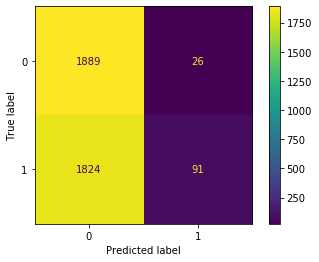

In [215]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

In [216]:
from sklearn.metrics import average_precision_score, roc_auc_score

average_precision_score(y_true, y_pred)

0.5131998839570641

In [217]:
roc_auc_score(y_true, y_pred)

0.5169712793733682

### TreeBoostler

In [218]:
import sys  
sys.path.insert(0, '../TreeBoostler')

from revision import *
from transfer import *
from mapping import *
from boostsrl import boostsrl
import os

predicate = 'cites'
to_predicate = 'interaction'

def print_function(message):
    global experiment_title
    global nbr
    if not os.path.exists('experiments/' + experiment_title):
        os.makedirs('experiments/' + experiment_title)
    with open('experiments/' + experiment_title + '/' + str(nbr) + '_' + experiment_title + '.txt', 'a') as f:
        print(message, file=f)
        print(message)

In [219]:
transferred_structured = structured_src
tr_file = transfer.get_transfer_file(bk['yeast2'], bk['yeast'], predicate, to_predicate, searchArgPermutation=True, allowSameTargetMap=False)
new_target = to_predicate

In [220]:
tr_train_pos = []
tr_train_neg = []
tr_train_facts = []

for i in range(0, len(train_pos)):
    tr_train_pos.extend(train_pos[i])
    tr_train_neg.extend(train_neg[i])
    tr_train_facts.extend(train_facts[i])

In [221]:
# transfer and revision theory
experiment_title = 'Yeat2 -> Yeast'
nbr = 1
background = boostsrl.modes(bk['yeast'], [to_predicate], useStdLogicVariables=False, maxTreeDepth=3, nodeSize=2, numOfClauses=8)
[model, t_results, structured, pl_t_results] = revision.theory_revision(background, boostsrl, target, tr_train_pos, tr_train_neg, tr_train_facts, test_pos, test_neg, test_facts, structured_src, transfer=tr_file, trees=9, max_revision_iterations=1, print_function=print_function)


******************************************
Performing Parameter Learning
******************************************
Refine
0;;cites(A, B) :- chem(A, C).;true;false
0;true;dmhead(A, D).;true;true
0;true,true;qmhead(A, E).;true;true
0;true,true,true;author(A, F), fauthor(A, F).;false;false
0;true,true,false;gene(B, G).;false;false
0;true,false;lauthor(A, H), author(I, H).;true;true
0;true,false,true;dmhead(B, J), qmhead(B, K).;false;false
0;true,false,false;lauthor(A, L), fauthor(M, L).;false;false
1;;cites(A, B) :- chem(A, C).;true;false
1;true;lauthor(A, D), fauthor(E, D).;true;true
1;true,true;fauthor(B, F), lauthor(G, F).;true;true
1;true,true,true;chem(G, C).;false;false
1;true,true,false;qmhead(E, H), qmhead(A, I).;false;false
1;true,false;qmhead(A, J), dmhead(A, K).;true;true
1;true,false,true;fauthor(A, L), lauthor(M, L).;false;false
1;true,false,false;qmhead(A, N).;false;false
2;;cites(A, B) :- fauthor(A, C), lauthor(D, C).;true;true
2;true;qmhead(B, E), chem(B, F).;false;true
2

Results
   AUC ROC   = 0.526451
   AUC PR    = 0.529524
   CLL	      = -0.694774
   Precision = 0.622137 at threshold = 0.5
   Recall    = 0.085117
   F1        = 0.149747


Total learning time: 368.602 seconds
Total inference time: 10.72 seconds
AUC ROC: 0.526451


Results scoring model
   AUC ROC   = 0.58289
   AUC PR    = 0.571422
   CLL	      = -0.688836
   Precision = 0.657596 at threshold = 0.5
   Recall    = 0.113326
   F1        = 0.193333


Total scoring time: 45.363 seconds
Parameter learned model CLL: -0.688836


Structure after Parameter Learning
[['interaction(A, B)', {'': 'complex(A, C)', 'true': 'phenotype(A, D)', 'true,true': 'location(A, E)', 'true,true,true': 'enzyme(A, F)', 'true,true,false': 'function(B, G)', 'true,false': 'enzyme(H, I)', 'true,false,true': 'phenotype(B, J), location(B, K)'}, {'true,true,true,true': [9.247, 171, 171], 'true,true,true,false': [18.888, 713, 714], 'true,true,false,true': [0.707, 1, 1], 'true,true,false,false': [0.0, 0, 0], 'true,false,